In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error

# 1. Load M2 Data
df_m2 = pd.read_csv('../data/raw/M2SL.csv', parse_dates=['observation_date'], index_col='observation_date')
df_m2.rename(columns={'M2SL': 'M2'}, inplace=True)

# 2. Load Interest Rate Data (FEDFUNDS)
df_rate = pd.read_csv('../data/raw/FEDFUNDS.csv', parse_dates=['observation_date'], index_col='observation_date')

# 3. Merge Datasets
# Inner join ensures we only keep dates present in both files
df_multi = pd.concat([df_m2, df_rate], axis=1).dropna()

print("Merged Dataset Head:")
print(df_multi.head())

Merged Dataset Head:
                     M2  FEDFUNDS
observation_date                 
1959-01-01        286.6      2.48
1959-02-01        287.7      2.43
1959-03-01        289.2      2.80
1959-04-01        290.1      2.96
1959-05-01        292.2      2.90


VAR Training samples: 641
VAR Test samples:     160


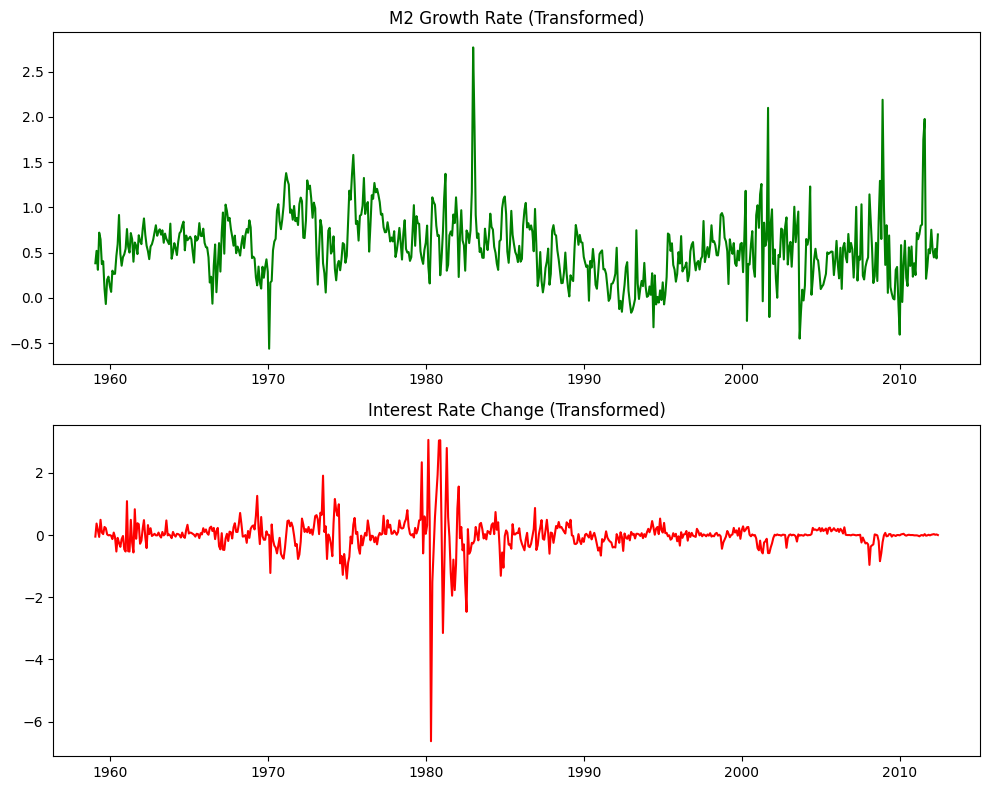

In [6]:
# 4. Data Transformations for Stationarity
# M2 -> Monthly Growth Rate (Log Difference * 100)
df_multi['M2_Growth'] = np.log(df_multi['M2']).diff() * 100

# FEDFUNDS -> First Difference (Change in Rate)
# We assume interest rates are non-stationary in levels
df_multi['Rate_Diff'] = df_multi['FEDFUNDS'].diff()

# Remove NaN values created by differencing
df_final = df_multi[['M2_Growth', 'Rate_Diff']].dropna()

# 5. Train-Test Split (Chronological 80/20)
n_obs = len(df_final)
n_test = int(n_obs * 0.2)
n_train = n_obs - n_test

train_var = df_final.iloc[:n_train]
test_var = df_final.iloc[n_train:]

print(f"VAR Training samples: {len(train_var)}")
print(f"VAR Test samples:     {len(test_var)}")

# Plot Transformed Variables
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
axes[0].plot(train_var['M2_Growth'], color='green')
axes[0].set_title('M2 Growth Rate (Transformed)')
axes[1].plot(train_var['Rate_Diff'], color='red')
axes[1].set_title('Interest Rate Change (Transformed)')
plt.tight_layout()
plt.show()

In [7]:
# 6. Select Optimal Lag Order (AIC)
model = VAR(train_var)

# Check lags up to 15 months
lag_order_results = model.select_order(maxlags=15)
print(lag_order_results.summary())

# Extract best lag based on AIC
optimal_lag = lag_order_results.aic
print(f"\nSelected Optimal Lag (p): {optimal_lag}")

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -3.271      -3.257     0.03796      -3.266
1       -3.872      -3.829     0.02083      -3.855
2       -3.915      -3.844     0.01994      -3.888
3       -3.946     -3.846*     0.01934      -3.907
4       -3.946      -3.818     0.01933      -3.896
5       -3.969      -3.813     0.01890      -3.908
6       -3.964      -3.780     0.01898      -3.893
7       -3.965      -3.753     0.01896      -3.883
8       -4.015      -3.774     0.01805     -3.921*
9       -4.021      -3.751     0.01794      -3.916
10      -4.023      -3.725     0.01790      -3.907
11      -4.032      -3.706     0.01773      -3.906
12      -4.022      -3.668     0.01791      -3.884
13      -4.050      -3.667     0.01742      -3.901
14      -4.051      -3.640     0.01740      -3.892
15     -4.052*      -3.613    0.01738*      -3.882
-------------------------------

Starting VAR Rolling Forecast (1-step ahead)...

VAR Model Results:
RMSFE: 0.5462
MAE:   0.2677


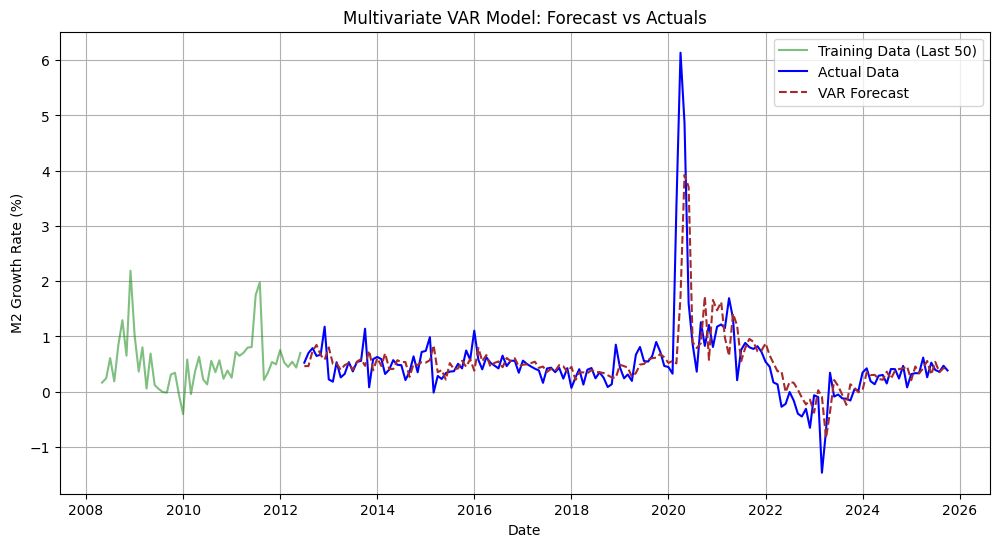

In [8]:
print("Starting VAR Rolling Forecast (1-step ahead)...")

# Initialize history with training data
history = train_var.values.tolist()
predictions = []

# Loop through the test set
for i in range(len(test_var)):
    
    # Create a DataFrame for the current history
    curr_data = pd.DataFrame(history, columns=['M2_Growth', 'Rate_Diff'])
    
    # Fit VAR model on current history
    # Note: We re-estimate the model at each step to incorporate new information
    model_fit = VAR(curr_data).fit(optimal_lag)
    
    # Forecast the next step (1 step ahead)
    # We provide the last 'p' observations required for prediction
    last_obs = np.array(history)[-optimal_lag:]
    fc = model_fit.forecast(y=last_obs, steps=1)
    
    # fc returns predictions for both variables [M2_pred, Rate_pred]
    # We extract M2 prediction (index 0)
    pred_m2 = fc[0][0]
    predictions.append(pred_m2)
    
    # Add actual observation (M2 and Rate) to history for the next iteration
    history.append(test_var.iloc[i].values.tolist())

# Create DataFrame for comparison
var_forecast_df = pd.DataFrame({
    'Actual': test_var['M2_Growth'],
    'VAR_Forecast': predictions
}, index=test_var.index)

# Calculate Evaluation Metrics
mse = mean_squared_error(test_var['M2_Growth'], predictions)
rmsfe = np.sqrt(mse)
mae = np.mean(np.abs(test_var['M2_Growth'] - predictions))

print(f"\nVAR Model Results:")
print(f"RMSFE: {rmsfe:.4f}")
print(f"MAE:   {mae:.4f}")

# Plotting Forecast vs Actuals
plt.figure(figsize=(12, 6))
plt.plot(train_var.index[-50:], train_var['M2_Growth'][-50:], label='Training Data (Last 50)', color='green', alpha=0.5)
plt.plot(test_var.index, test_var['M2_Growth'], label='Actual Data', color='blue')
plt.plot(var_forecast_df.index, var_forecast_df['VAR_Forecast'], label='VAR Forecast', color='brown', linestyle='--')

plt.title('Multivariate VAR Model: Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('M2 Growth Rate (%)')
plt.legend()
plt.grid(True)
plt.show()